In [6]:
import torch
from squeeze_pose_net import SqueezePoseNetDecoder, SqueezePoseNetEncoder
from decoder import ConvDecoder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch import nn
import torchvision.transforms as transforms
import pickle
import random

In [2]:
# data preperation
batch_size = 30
train_test_ratio = 0.7

with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_fixed_mono8_10k_norm.pkl", 'rb') as f:
    data = pickle.load(f)

pose, img = data

print(pose.shape, img.shape)

ratio_id = int(data[0].shape[0] * train_test_ratio)

train_pose = pose[:ratio_id]
train_img = img[:ratio_id]
test_pose = pose[ratio_id:]
test_img = img[ratio_id:]

train_set = TensorDataset(torch.from_numpy(train_pose).float(), torch.from_numpy(train_img).float())
test_set = TensorDataset(torch.from_numpy(test_pose).float(), torch.from_numpy(test_img).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

(10000, 2) (10000, 256, 256)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
print('Device: ', device)

preprocess = transforms.Compose([
    transforms.CenterCrop(244)
])

epochs = 200

net = SqueezePoseNetDecoder(1, 2)

net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.95)
criterion = nn.MSELoss()

train_loss_epoch = []
train_loss_total = []

test_loss_epoch = []
test_loss_total = []

for epoch in range(epochs):
    net.train()
    train_loss_batch = []
    for i, (pose, img) in enumerate(train_loader):
        pose = pose.unsqueeze(1).to(device)
        img = preprocess(img).unsqueeze(1).to(device)

        optimizer.zero_grad()  # zero the gradient buffers
        output = net(pose)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()  # Does the update
        loss = loss.item()

        train_loss_batch.append(loss)
        train_loss_total.append(loss)

    scheduler.step()

    train_loss_epoch.append(np.mean(train_loss_batch))
    
    if epoch%1==0:
        net.eval()
        test_loss_batch = []
        for i, (pose, img) in enumerate(test_loader):
            pose = pose.unsqueeze(1).to(device)
            img = preprocess(img).unsqueeze(1).to(device)

            optimizer.zero_grad()  # zero the gradient buffers
            output = net(pose)
            loss = criterion(output, img)
            loss = loss.item()

            test_loss_batch.append(loss)
            test_loss_total.append(loss)
        
        test_loss_epoch.append(np.mean(test_loss_batch))

        print('------ Epoch ', epoch)
        print('Epoch loss:', train_loss_epoch[-1])
        print('Val loss:', test_loss_epoch[-1])
        torch.save(net.state_dict(), "SPN_Dec_2_100e.pt")

[0.68466667 0.6797446 ]


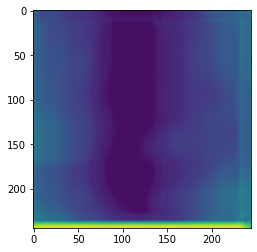

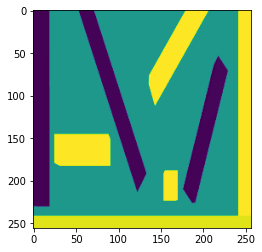

[0.32794444 0.84352643]


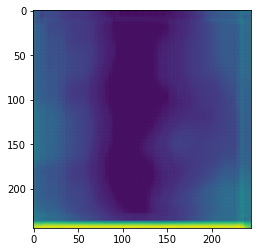

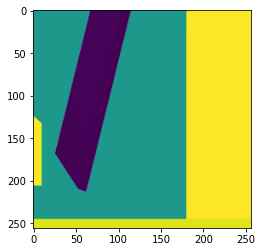

[0.07116667 0.8463728 ]


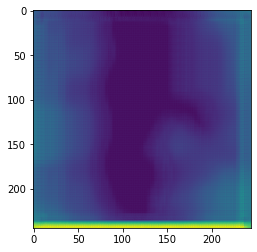

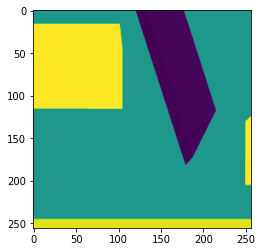

[0.21494444 0.87891376]


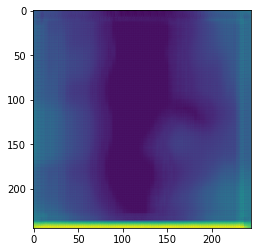

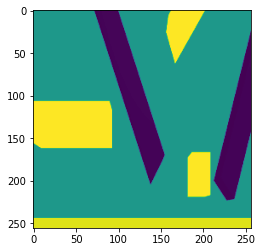

[0.75933333 0.41987845]


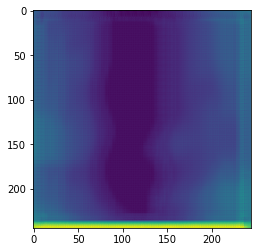

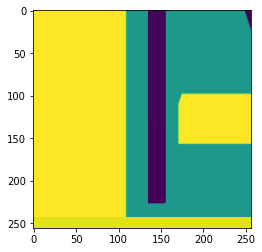

[0.08944444 0.91091622]


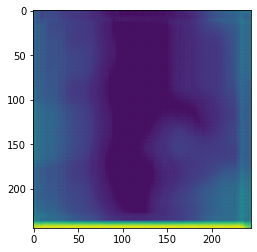

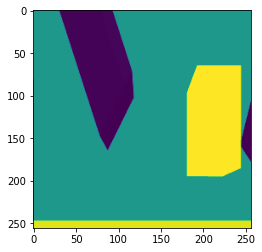

[0.97488889 0.71643973]


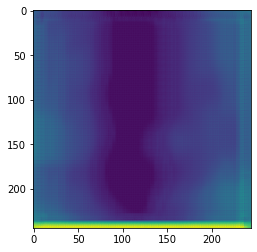

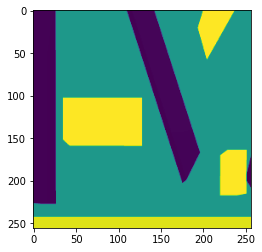

[0.38138889 0.67835987]


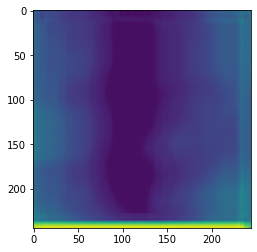

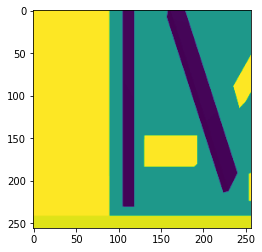

[0.21227778 0.91130087]


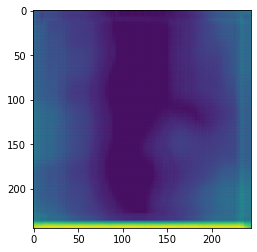

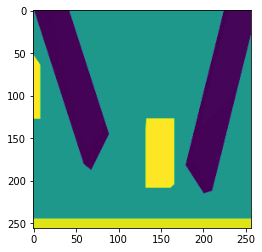

[0.41844444 0.3061774 ]


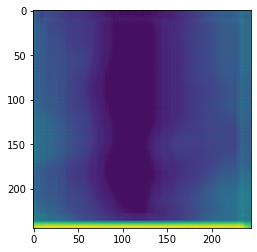

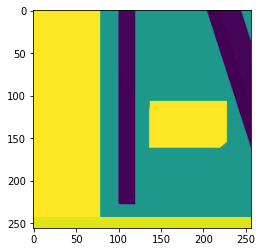

In [8]:
for i in random.sample(range(len(test_pose)), 10):
    print(test_pose[i])
    plt.imshow(net(torch.tensor(test_pose[i]).float().cuda()).cpu().detach().numpy().squeeze())
    plt.show()
    plt.imshow(test_img[i])
    plt.show()